In [85]:
# IPython magig  tools
%load_ext autoreload
%autoreload 2

from matplotlib import patches as mpatches
import sys
sys.path.append('../../../src/')

import os

from aind_vr_foraging_analysis.utils import parse, processing, plotting_utils as plotting, AddExtraColumns

# Plotting libraries
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
from scipy.optimize import curve_fit
import math 
from os import PathLike
from pathlib import Path

sns.set_context('talk')

import warnings
pd.options.mode.chained_assignment = None  # Ignore SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

pdf_path = r'Z:\scratch\vr-foraging\sessions'
base_path = r'Z:\scratch\vr-foraging\data'
data_path = r'../../../data/'

color1='#d95f02'
color2='#1b9e77'
color3='#7570b3'
color4='#e7298a'
odor_list_color = [color1, color2, color3]
color_dict = {0: color1, 1: color2, 2: color3}
color_dict_label = {'Ethyl Butyrate': color1, 'Alpha-pinene': color2, 'Amyl Acetate': color3, 
                    '2-Heptanone' : color2, 'Methyl Acetate': color1, 'Fenchone': color3, '2,3-Butanedione': color4,
                    'Methyl Butyrate': color1}
# color_dict_label = {'Ethyl Butyrate': '#d95f02', 'Alpha-pinene': '#1b9e77', 'Amyl Acetate': '#7570b3', 
#                     '2-Heptanone' : '#1b9e77', 'Methyl Acetate': '#d95f02', 'Fenchone': '#7570b3', '2,3-Butanedione': '#e7298a'}
dict_odor = {}
rate = 1
offset = 1
dict_odor['Ethyl Butyrate'] = {'rate':rate, 'offset':offset, 'color': '#d95f02'}
dict_odor['Alpha-pinene'] = {'rate':rate, 'offset':offset, 'color': '#1b9e77'}
dict_odor['Amyl Acetate'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['Methyl Acetate'] = {'rate':rate, 'offset':offset, 'color': color1}
dict_odor['2,3-Butanedione'] = {'rate':rate, 'offset':offset, 'color': color4}
dict_odor['Fenchone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}
dict_odor['2-Heptanone'] = {'rate':rate, 'offset':offset, 'color': '#7570b3'}

# Define exponential function
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def format_func(value, tick_number):
    return f"{value:.0f}"

results_path = r'C:\Users\tiffany.ona\OneDrive - Allen Institute\Documents\VR foraging\experiments\batch 4 - manipulating cost of travelling and global statistics\results'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
date = datetime.date.today()
date_string = "9/9/2024"
date = datetime.datetime.strptime(date_string, "%m/%d/%Y").date()

In [ ]:
summary_df = pd.DataFrame()
all_epochs = pd.DataFrame()
previous_experiment = 0

for mouse in ['754570','754579','754567','754580','754559','754560','754577','754566','754570','754571','754572','754573','754574','754575', '754582','745302','745305','745301']:
    print(mouse)
    session_n = 0
    directory = os.path.join(base_path, mouse)
    files = os.listdir(os.path.join(base_path, mouse))

    sorted_files = sorted(files, key=lambda x: os.path.getctime(os.path.join(directory, x)), reverse=False)

    # All this segment is to find the correct session without having the specific path
    for file_name in sorted_files:

        print(file_name)
        # Find specific session sorted by date
        session = file_name[-15:-7]
        if datetime.datetime.strptime(session, "%Y%m%d").date() < date:
            continue
        else:
            print('correct date found')
            
        # Recover data streams
        session_path = os.path.join(base_path, mouse, file_name)
        session_path = Path(session_path)
        try:
            data = parse.load_session_data(session_path)
        except:
            print('Error loading data')
              
        data['config'].streams['tasklogic_input'].load_from_file()
               
        # Parse data
        try:
            reward_sites, active_site, config = parse.parse_dataframe(data)
        except:
            print('Error parsing data')
            continue
        
        odor_sites = AddExtraColumns(reward_sites, active_site, run_on_init=True).reward_sites
        odor_sites['perceived_reward_probability'] = reward_sites['after_choice_cumulative_rewards'] / (reward_sites['visit_number'] +1)
        
        # Remove segments where the mouse was disengaged
        last_engaged_patch = odor_sites['active_patch'][odor_sites['skipped_count'] >= 10].min()
        if pd.isna(last_engaged_patch):
            last_engaged_patch = odor_sites['active_patch'].max()
            
        odor_sites['engaged'] = odor_sites['active_patch'] <= last_engaged_patch  
        
        active_site = AddExtraColumns(odor_sites, active_site).add_time_previous_intersite_interpatch()
        active_site['duration_epoch'] = active_site.index.to_series().diff().shift(-1)
        active_site['mouse'] = mouse
        active_site['session'] = session       
        session_n+=1
        
        experiment = data['config'].streams.tasklogic_input.data['stage_name']
        if previous_experiment != experiment:
            within_session_number = 0
            previous_experiment = experiment
        else:
            within_session_number += 1

        active_site['within_session_number'] = within_session_number   
        active_site['session_number'] = session_n
        active_site['experiment'] = data['config'].streams.tasklogic_input.data['stage_name']

        summary_df = pd.concat([summary_df, active_site])

754570
754570_20240823T104815
754570_20240903T122712
754570_20240904T114053
754570_20240905T112958
754570_20240906T105852
754570_20240911T131919
correct date found
754570_20240912T110112
correct date found
754570_20240913T111333
correct date found
754570_20240916T111512
correct date found
754570_20240917T110655
correct date found
754570_20240918T113619
correct date found
754570_20240919T110023
correct date found
754570_20240920T104959
correct date found
754570_20240923T104700
correct date found
754570_20240924T110456
correct date found
754570_20240925T110635
correct date found
754570_20240926T105051
correct date found
754570_20240927T104722
correct date found
754570_20240930T104239
correct date found
754570_20241001T104318
correct date found
754570_20241002T111428
correct date found
754570_20241003T111937
correct date found
754570_20241004T110425
correct date found
754570_20241007T111914
correct date found
754570_20241008T110907
correct date found
754570_20241009T111732
correct date fo

In [8]:
# summary_df.to_csv(os.path.join(data_path, 'batch_4.csv'))

In [93]:
print('Loading')
summary_df = pd.read_csv(os.path.join(data_path, 'batch_4.csv'))
summary_df['perceived_reward_probability'] = summary_df['cumulative_rewards'] / (summary_df['visit_number'] +1)
summary_df = summary_df[summary_df['engaged'] == True]

In [83]:
summary_df = summary_df[(summary_df['experiment'] == 'data_collection')|(summary_df['experiment'] == 'friction')|(summary_df['experiment'] == 'control')]

In [ ]:
onesession = summary_df[(summary_df['session'] == '20241016') & (summary_df['mouse'] == '754579')]
plotting.segmented_raster_vertical(onesession.loc[onesession.label == 'RewardSite'], 'test', color_dict_label=color_dict_label)

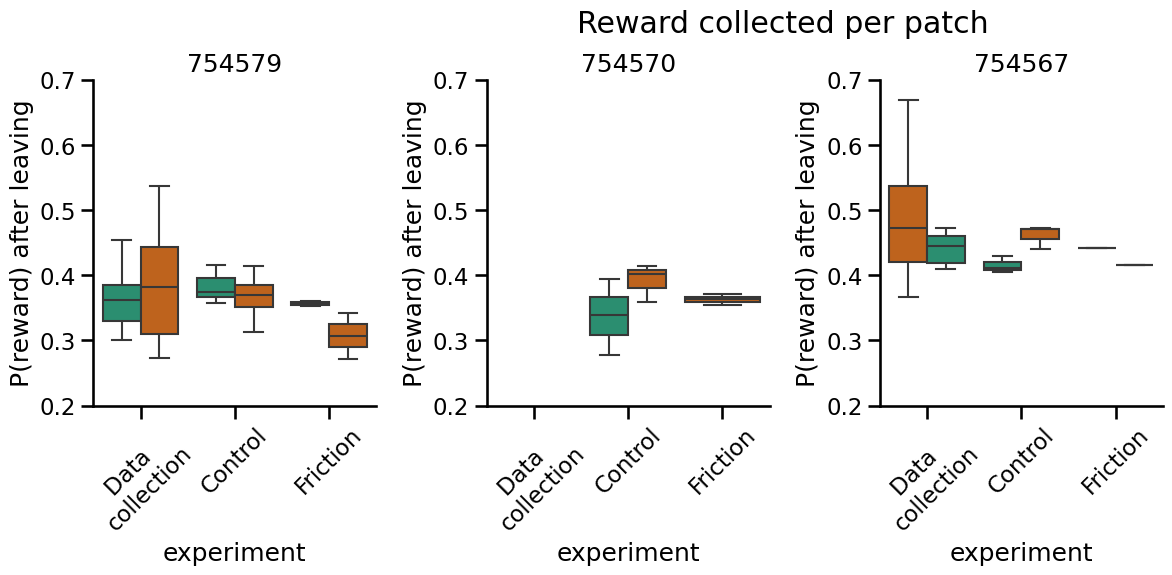

In [94]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 2)]
summary = summary.groupby(['session','mouse','odor_label', 'experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 20))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['data_collection', 'control', 'friction']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='reward_probability', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['data_collection', 'control', 'friction'])  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Data \ncollection', 'Control', 'Friction'], rotation = 45)
    plt.ylabel('P(reward) after leaving')
    plt.ylim(0.2, 0.7)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

## During session  p(reward) leave values

In [ ]:
for mouse_df in summary_df.groupby(['mouse']):
    mouse = mouse_df[1].mouse.unique()[0]
    for session_df in mouse_df[1].groupby(['session']):
        session = session_df[1].session.unique()[0]
        session_df = session_df[1]
        
        fig, ax = plt.subplots(1,2, figsize=(12,5), sharex=True)

        df = session_df.loc[(session_df.last_visit == 1)].groupby(['active_patch', 'odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
        df['visit_number'] = session_df.loc[(session_df.has_choice == True)].groupby(['active_patch', 'odor_label']).agg({'visit_number':'count'})['visit_number'].values[:len(df)]
        df = df.loc[df['visit_number']>1]
        if df.empty:
            continue
        
        sns.scatterplot(x='active_patch', y='perceived_reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[0], legend=False)
        ax[0].set_ylabel('Perceived reward probability')
        ax[0].set_xlabel('Patch number')
        ax[0].set_ylim(-0.1,1.1)

        odor_p = df.groupby(['odor_label']).agg({'perceived_reward_probability':'mean'}).reset_index()
        offset=0
        for i in range(len(odor_p)):
            ax[1].text(0.5, 0.1+offset, fontsize=10, s=f'{odor_p.odor_label.iloc[i]}: {odor_p.perceived_reward_probability.iloc[i]:.2f}', transform=ax[0].transAxes)
            offset+=0.05

        # Same for the perceived reward probability
        df = session_df.loc[(session_df.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min', 'visit_number':'count'}).reset_index()
        df['visit_number'] += 1
        df = df.loc[df['visit_number']>2]

        sns.scatterplot(x='active_patch', y='reward_probability', size="visit_number", sizes=(10, 300), data=df, hue='odor_label', palette=[color1, color2, color3], ax = ax[1])
        ax[1].set_ylabel('Reward probability')
        ax[1].set_xlabel('Patch number')
        ax[1].set_ylim(-0.1,1.1)

        odor_p = df.groupby(['odor_label']).agg({'reward_probability':'mean'}).reset_index()
        offset=0
        for i in range(len(odor_p)):
            ax[1].text(1.5, 0.1+offset, fontsize=10, s=f'{odor_p.odor_label.iloc[i]}: {odor_p.reward_probability.iloc[i]:.2f}', transform=ax[0].transAxes)
            offset+=0.05
        
        plt.legend(bbox_to_anchor=(1.0,0.8), loc='upper left', labels=[max(df.visit_number)], markerscale=1.3, title='# visits')
        plt.suptitle(f'{mouse} {session} - {session_df.experiment.unique()[0]} - {session_df.session_number.unique()[0]}')
        sns.despine()
        plt.show()


In [ ]:
with PdfPages(os.path.join(results_path, 'across_sessions_parameters_batch4.pdf')) as pdf:
    for mouse_df in summary_df.groupby(['mouse']):
        mouse = mouse_df[1].mouse.unique()[0]
        for session_df in mouse_df[1].groupby(['session']):
            session = session_df[1].session.unique()[0]
            session_df = session_df[1]
            fig, ax = plt.subplots(3,1,figsize=(12,14), sharex=True)

            reward_sites = summary_df.loc[(summary_df['session'] == session)&(summary_df['mouse'] == mouse)&(summary_df['label'] == 'RewardSite')]

            patch_number = len(reward_sites.active_patch.unique())
            number_odors = len(reward_sites['odor_label'].unique())

            list_odors = []
            for odor in reward_sites.odor_label.unique():
                list_odors.append(reward_sites.loc[reward_sites.odor_label == odor].active_patch.nunique())
            grid = (np.array(list_odors)/patch_number)*number_odors

            for index, row in reward_sites.iterrows():
                if row['reward_delivered'] == 1 and row['has_choice'] == True:
                    color='steelblue'
                elif row['reward_delivered'] == 0 and row['has_choice'] == True:
                    color='pink'
                    if row['reward_available'] == 0:
                        color='crimson'
                else:
                    if  row['reward_available'] == 0:
                        color='black'
                        hatch = '/'
                    else:
                        color='lightgrey'
                    
                ax[0].bar(int(row['active_patch']), bottom=row['visit_number'], height=1, width=0.8, color=color, edgecolor='darkgrey', linewidth=0.5)
                ax[0].set_xlim(-1,max(reward_sites.active_patch)+1)
                ax[0].set_xlim(-1,50)
                ax[0].set_xlabel('Patch number')
                ax[0].set_ylabel('Site number')
                
                # ax1.bar(int(row['active_patch']), bottom = -1, height=0.5, width = 1, color=patch_color, edgecolor='black', linewidth=0.5)
                ax[0].scatter(row['active_patch'], -0.6, color=color_dict_label[row['odor_label']], marker='s', s=60, edgecolor='black', linewidth=0.0)
                ax[1].scatter(row['active_patch'], -0.6, color=color_dict_label[row['odor_label']], marker='s', s=60, edgecolor='black', linewidth=0.0)

            odors = []
            for index, odor in enumerate(reward_sites['odor_label'].unique()):
                odors.append(mpatches.Patch(color=color_dict_label[odor], label=(str(odor) + '_' + str(reward_sites.loc[reward_sites.odor_label == odor].reward_probability.max()))))

            label_2 = mpatches.Patch(color='steelblue', label='Harvest, rewarded')
            label_3 = mpatches.Patch(color='pink', label='Harvest, no reward')
            label_4 = mpatches.Patch(color='lightgrey', label='Leave')

            odors.extend([label_2, label_3,label_4])
            plt.legend(handles=odors, loc='right', bbox_to_anchor=(0.75, 1), fontsize=12, ncol=2)
            ax[0].set_ylim(-2,max(reward_sites.visit_number)+1)

            summary = reward_sites.groupby(['active_patch','odor_label']).agg({'reward_delivered':'sum','has_choice':'sum'})
            summary.reset_index(inplace=True)

            sns.barplot(x='active_patch', y='has_choice',data=summary, color='pink', ax=ax[1], errorbar=None, legend=False)
            for p in ax[1].patches:
                ax[1].annotate(f'{int(p.get_height())}',  # The count
                            (p.get_x() + p.get_width() / 2., p.get_height()),  # Position
                            ha='center', va='center', 
                            xytext=(0, 9), fontsize=9,  # 9 points vertical offset
                            textcoords='offset points')
            sns.barplot(x='active_patch', y='reward_delivered', hue='odor_label', palette= color_dict_label, data=summary, legend=False, ax=ax[1], errorbar=None)

            # Specifying the number of xticks
            num_ticks = 10  # Change this to the desired number of ticks
            xticks = np.linspace(summary.active_patch.min(), summary.active_patch.max(), num_ticks)

            # Specifying the xticks
            ax[1].set_xticks(xticks)
            # ax[1].set_xlim(-1,125)
            ax[1].set_ylim(-1.5,reward_sites.visit_number.max()+1)
            ax[1].set_ylabel('Site number')

            df = session_df.loc[(session_df.last_site == 1)&(session_df.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min','visit_number':'mean'}).reset_index()
            # sns.scatterplot(x='active_patch', y='reward_probability', color='b', s=50, marker='o',  zorder=10, hue='odor_label', palette=color_dict_label, data = df, ax = ax[2], legend=False)
            # sns.lineplot(x='active_patch', y='reward_probability', marker='',color='grey', alpha=0.5, data = df, ax = ax[2], legend=False)
            
            sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax[2], legend=False)
            
            ax[2].set_xlabel('Patch number')
            ax[2].set_ylabel('P(reward) when leaving')            
            ax[2].set_ylim(-0.1,1.1)
            
            plt.suptitle(f'{mouse} {session} - session {session_df.session_number.unique()[0]} - {session_df.experiment.unique()[0]}')
            sns.despine()
            plt.tight_layout()
            plt.show()
            pdf.savefig(fig)


In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Methyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]

summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['data_collection', 'control', 'friction']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='', ax=ax)

        plt.title(f'{experiment}')

        if experiment == 'base':
            plt.hlines(0.9, 1, 18, color=color1, linestyle='--', alpha=0.5)
            plt.hlines(0.6, 1, 18, color=color2, linestyle='--', alpha=0.5)

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(0.10,0.91)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

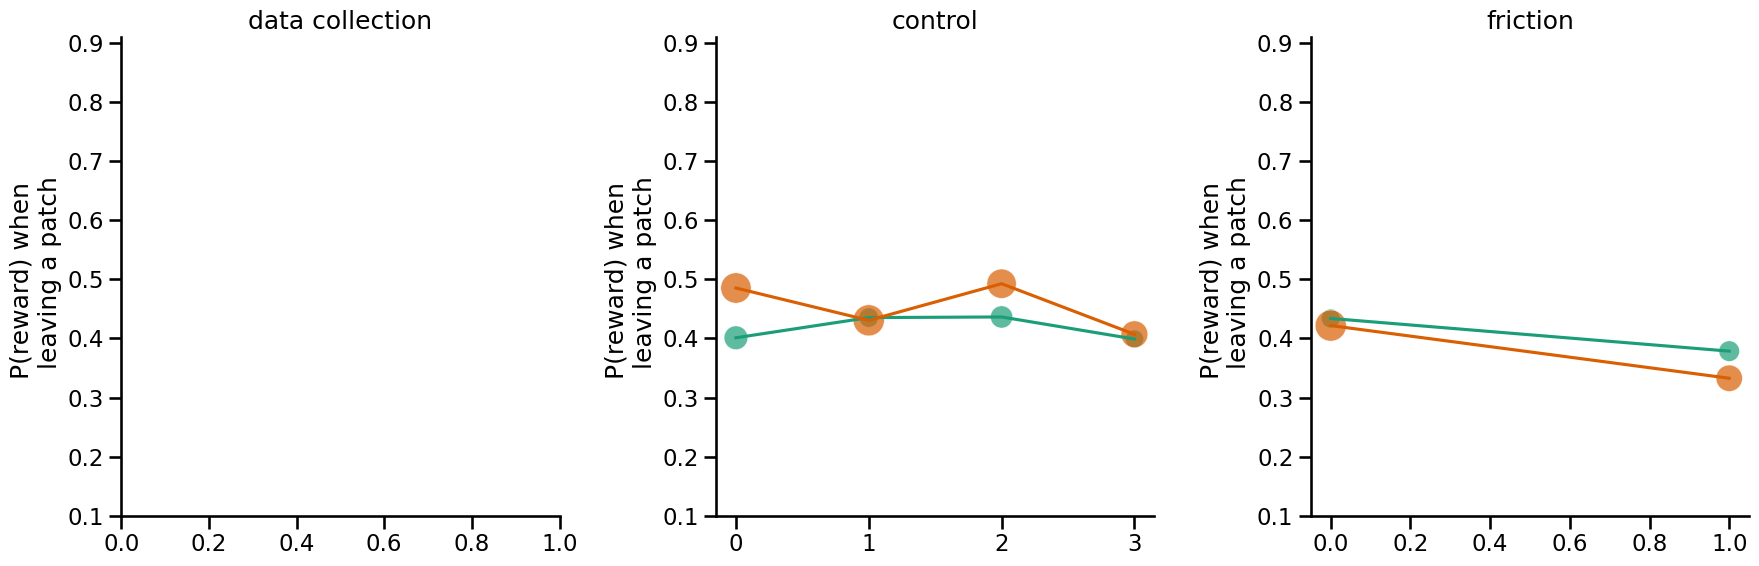

In [95]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[(summary.visit_number > 0)]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()
summary = summary.groupby(['within_session_number','odor_label','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

fig = plt.figure(figsize=(18,6))

# print(summary.loc[summary.mouse == mouse])
# print('\n')
for i, experiment in enumerate(['data collection', 'control', 'friction']):
    ax = plt.subplot(1, 3, i + 1)
        
    sns.scatterplot(summary.loc[(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax, legend=False, alpha=0.7)

    sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.experiment == experiment)], marker='', ax=ax)

    plt.title(f'{experiment}')

    if experiment == 'base':
        plt.hlines(0.9, 1, 18, color=color1, linestyle='--', alpha=0.5)
        plt.hlines(0.6, 1, 18, color=color2, linestyle='--', alpha=0.5)

    plt.xlabel('')
    plt.ylabel('P(reward) when \n leaving a patch')
    plt.ylim(0.10,0.91)
    sns.despine()
    
# plt.suptitle(f'{mouse}')
plt.tight_layout()
plt.show()

fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
def summary_withinsession_values(reward_sites, 
                                 color_dict_label = {'Ethyl Butyrate': '#d95f02', 'Alpha-pinene': '#1b9e77', 'Amyl Acetate': '#7570b3',
                                                     '2-Heptanone' : '#1b9e77', 'Methyl Acetate': '#d95f02', 'Fenchone': '#7570b3', '2,3-Butanedione': '#e7298a'}, 
                                 save=None):

    fig, ax = plt.subplots(3,2,figsize=(16,10), sharex=True)

    df = reward_sites.loc[(reward_sites.last_site == 1)&(reward_sites.visit_number != 0)].groupby(['active_patch', 'odor_label']).agg({'reward_probability':'min','visit_number':'mean', 'cumulative_rewards': 'max', 'consecutive_rewards': 'max', 'cumulative_failures': 'max', 'consecutive_failures': 'max'}).reset_index()

    ax[0][0].set_ylabel('P(reward) \n when leaving')            
    ax[0][0].set_ylim(-0.1,1.1)

    # df = df.groupby(['active_patch','odor_label']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()      
    sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', ax=ax[0][0], palette=color_dict_label,  legend=False)
    ax[0][0].set_ylabel('P(reward) \n when leaving')            
    ax[0][0].set_ylim(-0.1,1.1)

    sns.scatterplot(df, x='active_patch', hue='odor_label', sizes=(30, 500), y='visit_number', ax=ax[0][1], palette=color_dict_label,  legend=False)
    ax[0][0].set_ylabel('Total stops')            

    sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='consecutive_rewards', ax=ax[1][0], palette=color_dict_label,  legend=False)
    ax[0][0].set_ylabel('Consecutive rewards')            

    sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='cumulative_rewards', ax=ax[1][1], palette=color_dict_label,  legend=False)
    ax[0][0].set_ylabel('Cumulative rewards')            

    sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='cumulative_failures', ax=ax[2][0], palette=color_dict_label,  legend=False)
    ax[0][0].set_ylabel('Cumulative failures')            

    sns.scatterplot(df, x='active_patch', size="visit_number", hue='odor_label', sizes=(30, 500), y='consecutive_failures', ax=ax[2][1], palette=color_dict_label,  legend=False)
    ax[2][1].set_ylabel('Consecutive failures')            

    ax[2][0].set_xlabel('Patch number')
    ax[2][1].set_xlabel('Patch number')

    plt.tight_layout()
    sns.despine()
    if save:
        pdf.savefig(save)
    else:
        plt.show()

## Experienced curves across experiments

In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['mouse','experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    for experiment in summary.loc[summary['mouse'] == mouse].experiment.unique():
        fig, ax = plt.subplots(1,3,figsize=(13, 5))
        i = 0
        # for odor in dict_odor.keys():
        for odor in summary.loc[(summary['mouse'] == mouse)&(summary['experiment'] == experiment)].odor_label.unique():

            odor_df = summary.loc[(summary['odor_label'] == odor)&(summary['mouse'] == mouse)&(summary['experiment'] == experiment)]
            odor_df = odor_df.loc[(odor_df.visit_number_count >= 3.0)]

            sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', color=dict_odor[odor]['color'], ax=ax[i])
            
            if odor_df.empty:
                i +=1
                continue
            
            # Plot exponential curve
            popt, pcov = curve_fit(exponential_func, odor_df['cumulative_rewards'], odor_df['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color='black', label='Exponential Fit')
                # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.cumulative_rewards)/2, 0.85, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color='black', fontsize=10, )
                # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

            ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
            ax[i].set_ylim(-0.1,1.1)
            ax[i].set_title(odor)
            ax[i].set_xlabel('Total rewarded stops in patch')
            ax[i].set_ylabel('Percent Rewarded')

            i +=1

        sns.despine()
        plt.suptitle(f'{mouse} {experiment}')
        plt.tight_layout()
        plt.show()
        # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        


In [ ]:
summary = summary_df.loc[summary_df.has_choice == True].groupby(['mouse','experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

for mouse in summary.mouse.unique():
    i=0
    extra = 0.0
    fig, ax = plt.subplots(1,3,figsize=(13, 5))
    for experiment in summary.loc[summary['mouse'] == mouse].experiment.unique():
        # for odor in dict_odor.keys():
        odor_df = summary.loc[(summary['mouse'] == mouse)&(summary['experiment'] == experiment)]
        odor_df = odor_df.loc[(odor_df.odor_label != 'Amyl Acetate')&(odor_df.odor_label != 'Fenchone')]
        odor_df = odor_df.loc[(odor_df.visit_number_count >= 5.0)]

        sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', hue='odor_label', palette=color_dict_label, ax=ax[i])
    
        # Plot exponential curve
        extra = 0
        for odor in odor_df.odor_label.unique():
            extra += 0.08
            popt, pcov = curve_fit(exponential_func, odor_df.loc[(odor_df['odor_label'] == odor)]['cumulative_rewards'],odor_df.loc[(odor_df['odor_label'] == odor)]['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
            
            # Plot curve for this odor in theroy
            rate = dict_odor[odor]['rate']
            offset = dict_odor[odor]['offset']
            if popt[1] < 0:
                x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
                ax[i].plot(x_values, exponential_func(x_values, *popt), color=dict_odor[odor]['color'], label='Exponential Fit', alpha=0.5)
                # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
                ax[i].text(max(odor_df.cumulative_rewards)/2, 0.8+extra, f'y = {popt[0]:.2f} * e^({popt[1]:.2f} * x)', color=dict_odor[odor]['color'], fontsize=10, )
                # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

        ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
        ax[i].set_ylim(-0.1,1.1)
        ax[i].set_title(experiment)
        ax[i].set_xlabel('Total rewarded stops in patch')
        ax[i].set_ylabel('Percent Rewarded')

        i +=1
        
    sns.despine()
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()
        # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        


### Reconstruction from all experiments with all animals collapsed (same plot for all odors in a given xexperiment)

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)&(summary_df.environment == 'low')].groupby(['experiment','cumulative_rewards','odor_label']).agg({'collected':'count','reward_delivered':'sum','visit_number':'count'})
summary['percent_collected'] = summary['reward_delivered'] / summary['collected']
summary.rename(columns={'visit_number':'visit_number_count'}, inplace=True)
summary.reset_index(inplace=True)

i=0
extra = 0.0
fig, ax = plt.subplots(1,3,figsize=(13, 5))
for experiment in summary.experiment.unique():
    # for odor in dict_odor.keys():
    odor_df = summary.loc[(summary['experiment'] == experiment)]
    odor_df = odor_df.loc[(odor_df.odor_label != 'Amyl Acetate')&(odor_df.odor_label != 'Fenchone')]
    odor_df = odor_df.loc[(odor_df.visit_number_count >= 5.0)]

    sns.scatterplot(odor_df, x='cumulative_rewards', size="visit_number_count", sizes=(30, 500), y='percent_collected', hue='odor_label', palette=color_dict_label, ax=ax[i])

    # Plot exponential curve
    extra = 0
    for odor in odor_df.odor_label.unique():
        extra += 0.08
        popt, pcov = curve_fit(exponential_func, odor_df.loc[(odor_df['odor_label'] == odor)]['cumulative_rewards'],odor_df.loc[(odor_df['odor_label'] == odor)]['percent_collected'],maxfev = 600, bounds=([-np.inf, -np.inf], [np.inf, 1]))
        
        # Plot curve for this odor in theroy
        rate = dict_odor[odor]['rate']
        offset = dict_odor[odor]['offset']
        if popt[1] < 0:
            x_values = np.linspace(odor_df['cumulative_rewards'].min(), odor_df['cumulative_rewards'].max(), 100)
            ax[i].plot(x_values, exponential_func(x_values, *popt), color=dict_odor[odor]['color'], label='Exponential Fit', alpha=0.5)
            # ax[i].plot(x_values, exponential_func(x_values, offset, rate), color='grey', alpha=0.6, label='Exponential Fit')
            ax[i].text(max(odor_df.cumulative_rewards)/2, 0.8+extra, f'y = {popt[0]:.2f} * e^({popt[1]:.3f} * x)', color=dict_odor[odor]['color'], fontsize=10, )
            # ax[i].text(max(odor_df.cumulative_rewards)/2, 0.80, f'y = {offset} * e^({rate} * x)', color='grey', fontsize=10, )

    ax[i].legend(bbox_to_anchor=(0.0,0.3), loc='upper left', labels=[max(odor_df.visit_number_count)], markerscale=1.3, title='# visits')
    ax[i].set_ylim(-0.1,1.1)
    ax[i].set_title(experiment)
    ax[i].set_xlabel('Total rewarded stops in patch')
    ax[i].set_ylabel('Percent Rewarded')

    i +=1
    
sns.despine()
plt.tight_layout()
plt.show()
    # fig.savefig(foraging_figures+f'/pstop_fit_theory_{mouse}.svg', dpi=300, bbox_inches='tight')
        


## Total time in interpatch

In [ ]:
summary_df['next_site'] = summary_df['Seconds'].shift(-1)
summary_df['time_spent'] =  summary_df['next_site'] - summary_df.Seconds
summary_df.set_index('Seconds', inplace=True)
summary_df = summary_df.loc[summary_df['label'] == 'InterPatch']
summary_df = summary_df.loc[~((summary_df['mouse'] == 716456)&(summary_df['session_number'] >= 24))]

In [ ]:
df = summary_df.groupby(['mouse','session_number']).time_spent.median().reset_index()
fig = plt.figure(figsize=(8, 4))
sns.lineplot(data=df, x='session_number', y='time_spent', markers=True)
sns.despine()
plt.ylim(0,10)
plt.tight_layout()
plt.show()

In [ ]:
df = summary_df.groupby(['mouse','experiment','environment','session_number']).time_spent.median().reset_index()
fig = plt.figure(figsize=(12, 22))
for i, mouse in enumerate(df.mouse.unique()):
    ax = fig.add_subplot(6, 2, i+1)
    sns.lineplot(data=df.loc[df.mouse == mouse], x='session_number', y='time_spent', markers=True)
    plt.title(mouse)
    sns.despine()
    plt.ylim(0,10)
plt.tight_layout()
plt.show()

## Summary across all different experiments

In [ ]:
summary = summary_df.loc[(summary_df.visit_number != 0)&(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label','experiment', 'environment']).agg({'reward_delivered':'sum','visit_number':'count'})

summary = summary.groupby(['session','mouse','odor_label','experiment', 'environment']).agg({'reward_delivered':'mean','visit_number':'mean'})
summary.reset_index(inplace=True)
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 16))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        # Note: This is a conceptual step; you'll need to adjust based on your specific needs
        
        sns.boxplot(x='experiment', y='reward_delivered', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5)  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])
    plt.xlabel('Initial P(reward)')
    plt.ylabel('Total reward \n collected')
    # plt.ylim(-1, 10)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[summary.visit_number > 1]

widths = summary.groupby(['experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(10, 5))

for i, environment in enumerate(['high', 'low']):
    ax = plt.subplot(1, 2, i + 1)
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = widths.get(experiment, 1)  # Default to 1 if not found
        
        plot = summary.loc[(summary.environment !=environment)&(summary.experiment == experiment)].groupby(['mouse','odor_label','experiment'])['reward_delivered'].mean().reset_index()

        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='reward_delivered', hue='odor_label', legend=False,
                    palette=color_dict_label, data=plot,
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['base', 'experiment1', 'experiment2'])  # Example adjustment

        ax.set_title(environment)
        plt.ylabel('Total rewards')
        plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])

        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
        sns.despine()
        # plt.ylim(0.25,0.9)
            
        plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_collected_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice == True)].groupby(['session','mouse','active_patch','odor_label', 'experiment', 'environment']).agg({'collected':'sum','visit_number':'count'}).reset_index()
summary = summary.loc[(summary.visit_number > 1)]
summary = summary.groupby(['session','mouse','odor_label', 'experiment', 'environment']).agg({'collected':'mean','visit_number':'mean', 'active_patch': 'nunique'})
summary.reset_index(inplace=True)
# summary = summary.loc[summary.active_patch >= 10]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 16))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        # Note: This is a conceptual step; you'll need to adjust based on your specific needs
        
        sns.boxplot(x='experiment', y='visit_number', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5)  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])
    plt.xlabel('Initial P(reward)')
    plt.ylabel('Total stops')
    # plt.ylim(-1, 10)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[summary.visit_number > 1]

widths = summary.groupby(['experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(10, 5))

for i, environment in enumerate(['high', 'low']):
    ax = plt.subplot(1, 2, i + 1)
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = widths.get(experiment, 1)  # Default to 1 if not found
        
        plot = summary.loc[(summary.environment !=environment)&(summary.experiment == experiment)].groupby(['mouse','odor_label','experiment'])['visit_number'].mean().reset_index()

        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='visit_number', hue='odor_label', legend=False,
                    palette=color_dict_label, data=plot,
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['base', 'experiment1', 'experiment2'])  # Example adjustment

        ax.set_title(environment)
        plt.ylabel('Total stops')
        plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])

        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
        sns.despine()
        # plt.ylim(0.25,0.9)
            
        plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_collected_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['session','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
# summary = summary.loc[(summary.visit_number > 1)]
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
summary = summary.groupby(['session','mouse','odor_label', 'environment','experiment']).agg({'collected':'mean','reward_probability':'mean', 'active_patch': 'nunique'}).reset_index()
summary = summary.loc[summary.active_patch >= 10]

summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# Assuming 'summary' is your DataFrame
# Calculate the dynamic widths
widths = summary.groupby(['mouse', 'experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(16, 16))

for i, mouse in enumerate(summary.mouse.unique()):
    ax = plt.subplot(4, 4, i + 1)
    
    # Get the dynamic width for this mouse
    mouse_widths = widths.loc[mouse]
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = mouse_widths.get(experiment, 1)  # Default to 1 if not found
        
        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='reward_probability', hue='odor_label', legend=False,
                    palette=color_dict_label, data=summary.loc[(summary.mouse == mouse) & (summary.experiment == experiment)],
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['base', 'experiment1', 'experiment2'])  # Example adjustment
    
    # Additional plot adjustments
    plt.title(f'{mouse}')
    plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])
    plt.ylabel('P(reward) after leaving')
    # plt.ylim(-1, 10)
    sns.despine()

plt.suptitle('Reward collected per patch')
plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
# summary = summary_df.loc[~((summary_df.has_choice == False))].groupby(['session','mouse','active_patch','odor_label']).agg({'collected':'sum','visit_number':'count'}).reset_index()
# summary = summary.loc[summary.visit_number > 1]

widths = summary.groupby(['experiment', 'odor_label']).size().unstack(fill_value=0)
widths = widths.div(widths.sum(axis=1), axis=0)  # Normalize to get proportions

fig = plt.figure(figsize=(10, 5))

for i, environment in enumerate(['high', 'low']):
    ax = plt.subplot(1, 2, i + 1)
    
    # Plot each experiment with adjusted widths
    for experiment in ['base', 'experiment1', 'experiment2']:
        # Calculate the width for this experiment
        experiment_width = widths.get(experiment, 1)  # Default to 1 if not found
        
        plot = summary.loc[(summary.environment !=environment)&(summary.experiment == experiment)].groupby(['mouse','odor_label','experiment'])['reward_probability'].mean().reset_index()

        # Adjust the linewidth or dodge parameter based on experiment_width
        sns.boxplot(x='experiment', y='reward_probability', hue='odor_label', legend=False,
                    palette=color_dict_label, data=plot,
                    showfliers=False, ax=ax, linewidth=experiment_width * 1.5,  order=['base', 'experiment1', 'experiment2'])  # Example adjustment

        ax.set_title(environment)
        plt.ylabel('p(reward)')
        plt.xticks([0,1,2], ['Base', 'Exp1', 'Exp2'])

        # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Odor')
        sns.despine()
        plt.ylim(0.25,0.9)
            
        plt.tight_layout()

# fig.savefig(results_path+f'/prewardpecrease_total_reward_collected_average_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
from scipy import stats
results = stats.ttest_rel(summary.loc[summary['odor_label'] == 'Methyl Acetate'].groupby('mouse')['reward_probability'].mean(), summary.loc[summary['odor_label'] == '2,3-Butanedione'].groupby('mouse')['reward_probability'].mean())
print(results)

In [ ]:
summary_df.loc[summary_df.experiment=='experiment2'].to_csv(os.path.join(data_path, 'batch3_exp2.csv'), index=True)

### Within session progression and compared across experiments

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]

summary = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'visit_number':'sum', 'reward_probability':'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number", hue='odor_label', sizes=(30, 500), y='reward_probability', palette=color_dict_label, ax=ax, legend=False)

        # sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='o', ax=ax)

        # summary_average = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch', 'environment', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
        # summary_average = summary_average.loc[summary_average.active_patch >= 5]
        # summary_average = summary_average.groupby(['within_session_number','mouse', 'environment', 'experiment']).agg({'collected':'mean','reward_probability':'mean'}).reset_index()
        
        # sns.lineplot(x='within_session_number', y='reward_probability', color='black',  legend=False, data=summary_average.loc[(summary_average.mouse == mouse)&(summary_average.experiment == experiment)], marker='o')

        plt.title(f'{experiment}')

        if experiment == 'base':
            plt.hlines(0.9, 1, 18, color=color1, linestyle='--', alpha=0.5)
            plt.hlines(0.6, 1, 18, color=color2, linestyle='--', alpha=0.5)

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(0.10,0.91)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary = summary.loc[((summary.visit_number > 1)&(summary.odor_label == 'Ethyl Butyrate'))|(summary.experiment == 'experiment1')|(summary.odor_label == 'Alpha-pinene')|(summary.experiment == 'experiment2')]
# summary = summary.loc[(summary.visit_number > 0)]
summary = summary.loc[summary.active_patch >= 10]

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)

        sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='o', ax=ax)

        # summary_average = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch', 'environment', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
        # summary_average = summary_average.loc[summary_average.active_patch >= 5]
        # summary_average = summary_average.groupby(['within_session_number','mouse', 'environment', 'experiment']).agg({'collected':'mean','reward_probability':'mean'}).reset_index()
        
        # sns.lineplot(x='within_session_number', y='reward_probability', color='black',  legend=False, data=summary_average.loc[(summary_average.mouse == mouse)&(summary_average.experiment == experiment)], marker='o')

        plt.title(f'{experiment}')

        if experiment == 'base':
            plt.hlines(0.9, 1, 15, color=color1, linestyle='--', alpha=0.5)
            plt.hlines(0.6, 1, 15, color=color2, linestyle='--', alpha=0.5)

        plt.xlabel('')
        plt.ylabel('P(reward) when \n leaving a patch')
        plt.ylim(0.15,0.91)
        sns.despine()
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')

In [ ]:
summary = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch','odor_label', 'environment','experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
summary['visit_number_count'] = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment', 'active_patch'])['visit_number'].sum().values
summary = summary.loc[(summary.odor_label != 'Amyl Acetate')&(summary.odor_label != 'Fenchone')]

# summary = summary.loc[(summary.visit_number > 0)]
# summary = summary.loc[summary.active_patch >= 10]
summary = summary.groupby(['within_session_number','mouse','odor_label', 'environment','experiment']).agg({'visit_number':'mean', 'visit_number_count': 'mean'}).reset_index()

for mouse in summary.mouse.unique():
    fig = plt.figure(figsize=(18,6))

    # print(summary.loc[summary.mouse == mouse])
    # print('\n')
    for i, experiment in enumerate(['base', 'experiment1', 'experiment2']):
        ax = plt.subplot(1, 3, i + 1)
        # Define the y coordinates for two sets of values
        # odor_label1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[0]
        # odor_label2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].odor_label.unique()[1]
        
        # x = np.arange(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)].within_session_number.max())
        # y1 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label1)].reward_probability.reset_index().drop('index', axis=1).values
        # y2 = summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)&(summary.odor_label == odor_label2)].reward_probability.reset_index().drop('index', axis=1).values

        # # Connect the two sets of values with lines
        # for i in range(np.max(x)):
        #     ax.plot([x[i], x[i]], [y1[i], y2[i]], color='black', linestyle='-', alpha=0.5)
            
        sns.scatterplot(summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], x='within_session_number', size="visit_number_count", hue='odor_label', sizes=(30, 500), y='visit_number', palette=color_dict_label, ax=ax, legend=False)

        # sns.lineplot(x='within_session_number', y='reward_probability', hue='odor_label', palette = color_dict_label,  legend=False,  data=summary.loc[(summary.mouse == mouse)&(summary.experiment == experiment)], marker='o', ax=ax)

        # summary_average = summary_df.loc[(summary_df.has_choice ==True)].groupby(['within_session_number','mouse','active_patch', 'environment', 'experiment']).agg({'collected':'sum','visit_number':'count', 'reward_probability':'min'}).reset_index()
        # summary_average = summary_average.loc[summary_average.active_patch >= 5]
        # summary_average = summary_average.groupby(['within_session_number','mouse', 'environment', 'experiment']).agg({'collected':'mean','reward_probability':'mean'}).reset_index()
        
        # sns.lineplot(x='within_session_number', y='reward_probability', color='black',  legend=False, data=summary_average.loc[(summary_average.mouse == mouse)&(summary_average.experiment == experiment)], marker='o')

        plt.title(f'{experiment}')

        plt.xlabel('')
        plt.ylabel('Total stops')
        # plt.ylim(0.10,0.91)
        sns.despine()
        
    plt.suptitle(f'{mouse}')
    plt.tight_layout()
    plt.show()


# fig.savefig(results_path+f'/prewarddecrease_preward_when_leave_across_mice_{experiment}.svg', dpi=300, bbox_inches='tight')